# Informe Exploratorio

## Análisis Exploratorio y Selección de Modelos para mejorar métricas

En el mundo del análisis de datos y el modelado predictivo, una parte fundamental es comprender en detalle la naturaleza y el comportamiento de los datos con los que estamos trabajando ya que serán el insumo del entrenamiento del modelo. Esto se logra mediante un Análisis Exploratorio de Datos (EDA, por sus siglas en inglés), que nos permite examinar las características de nuestros datos, tanto numéricas como categóricas, y comprender su distribución, tendencias y posibles relaciones entre variables. Esta exploración inicial es crucial para tomar decisiones informadas sobre cómo proceder con el modelado y la predicción.

El objetivo principal de este informe es realizar un EDA exhaustivo de los datos disponibles hasta el momento, con el fin de entender mejor su estructura y características. Esto nos permitirá identificar posibles problemas, como datos faltantes, valores atípicos o distribuciones no esperadas, ver si hay alta multicolinealidad en datos, mirar cómo se comportan las variables categóricas, y tomar medidas para abordarlos de manera efectiva.

Además de la exploración de los datos, también nos proponemos seleccionar los modelos de clasificación más adecuados para nuestro conjunto de datos. Para lograr esto, evaluaremos el rendimiento de tres modelos ampliamente utilizados en la clasificación: Support Vector Machines (SVM), Random Forest Classifier y Gradient Boosting Trees. Estos modelos ofrecen enfoques diferentes para la clasificación y pueden adaptarse a una variedad de situaciones y tipos de datos. En este caso, para sacar la probabilidad de dicha clasificación, que al final de cuentas es el enfoque del proyecto

El proceso de selección de modelos implica entrenar y evaluar cada modelo utilizando métricas específicas, como la precisión (accuracy) y el recall. Además, exploraremos diferentes combinaciones de parámetros (hiperparámetros) para cada modelo, con el objetivo de encontrar la configuración óptima que maximice el rendimiento predictivo.

En resumen, este informe tiene como objetivo realizar un análisis exhaustivo de nuestros datos mediante un EDA detallado, seguido de la selección y evaluación de modelos de clasificación para predecir con precisión las etiquetas de clasificación, y posteriormente su probabilidad. Al finalizar, esperamos haber obtenido una comprensión profunda de nuestros datos y haber identificado el modelo o modelos que mejor se ajusten a nuestras necesidades de predicción.

## Analisis exploratorio de datos (EDA)

### Importación de librerias

In [1]:
# Importar las bibliotecas necesarias
import pandas as pd
import numpy as np
import geopandas as gpd
from sklearn.model_selection import train_test_split
import os
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC  # Para clasificación SVM
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer
from sklearn import metrics
from sklearn.model_selection import cross_val_score,GridSearchCV,ShuffleSplit
from sklearn import tree
from sklearn.metrics import accuracy_score,confusion_matrix,ConfusionMatrixDisplay,recall_score,precision_score,f1_score
import shap

c:\Users\Pc Com\anaconda3\envs\data_viz_env_financiera\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Fuente de datos

Importamos los conjuntos de datos de entrenamiento que contamos por el momento, provenientes de los archivos Eventos_SI_MM.csv y Eventos_NO_MM.csv proporcionados por la alcaldía de Cali. Estos contienen información sobre datos de precipitaciones y algunas características del suelo. 

A continuación podemos ver la biblioteca de datos de las variables iniciales a tomar en cuenta:


| Columna   | Descripción |
|------------|--------|
| Elevacion | Elevación del punto de movimiento en masa en metros sobre el nivel del mar (msnm) |
| Pendiente |  Pendiente del punto de movimiento en masa en porcentaje (%) |
| SIM_COB25 | Abreviatura del nombre de la cobertura de suelo Metodologia Land Corine Escala 1:25000 |
| GEOLOGIA_1 | Nomenclatura de la unidad geológica asociada al punto de movimiento en masa |
| P_24H | Lluvia acumulada en 24 horas en milímetros |
| P_7DIAS | Lluvia acumulada en 7 dias en milímetros |
| P_10DIAS | Lluvia acumulada en 10 dias en milímetros |
| P15DIAS | Lluvia acumulada en 15 dias en milímetros |
| P30DIAS | Lluvia acumulada en 30 dias en milímetros |
| P60DIAS | Lluvia acumulada en 60 dias en milímetros |
| P90DIAS | Lluvia acumulada en 90 dias en milímetros |
| deslizamientos | numero que indica si hubo deslizamiento de tierra en el punto de movimiento en masa |

Así mismo, traemos datos nuevos para poder testear el modelo y saber su comportamiento ante datos nunca ha visto, estos son `df_nuevos_datos` y vienen de las consultas a la API de la alcaldia de cali la cual contienen informacion acerca de la precipitacion del suelo que provienen de los sensores en las estaciones alrededor de la ciudad

### Importamos los datos

In [2]:
ruta_data = os.path.join('.', 'Data','output')
data_train='data_entrenamiento_modelo_SVM.csv'
data_new='cuadricula_datos_lluvia.json'

In [3]:
# Cargar los datos desde un archivo CSV
df = pd.read_csv(
    os.path.join(ruta_data, data_train)
    )

# Se carga el dataframe con los datos nuevos el cual va a predecir el modelo 
df_nuevos_datos = gpd.read_file(
    os.path.join(ruta_data, data_new)
    )

In [4]:
# Se reemplaza los nombres de las columnas para el entrenamiento de acuerdo al dataframe que va a recibir el modelo
df = df.rename(columns={'Elevacion':'ELEVACION', 'Pendiente':'PENDIENT', 'P_24H':'24h','P_7DIAS':'7d', 'P_10DIAS' : '10d',
                        'P15DIAS': '15d','P30DIAS' : '30d', 'P60DIAS' : '60d', 'P90DIAS' : '90d'})

Re-ordenamos los registros de manera aleatoria para que pierdan el orden que tenian

In [5]:
df=df.sample(frac=1,replace=False)

In [6]:
df_nuevos_datos=df_nuevos_datos[df_nuevos_datos['id'] != -1]

In [7]:
df.head()

,ELEVACION,PENDIENT,SIM_COB25,GEOLOGIA_1,24h,7d,10d,15d,30d,60d,90d,deslizamientos
413,1086.934937,94.294182,ZUD,Kv,0.0,78.3,105.0,137.7,178.0,318.2,374.0,1
644,1088.329102,11.077402,VEGSEC,TOg,0.0,0.9,14.0,14.2,64.7,222.4,0.0,0
51,1051.061279,8.331034,ZUC,Kv,10.0,167.0,188.0,313.0,456.0,536.0,694.0,1
311,1058.672974,56.150898,ZUC,Kv,0.0,18.0,28.0,220.0,431.0,753.0,859.0,1
15,1190.523560,84.404579,ZUC,TOg,0.0,1.6,2.0,2.4,100.4,137.8,180.0,1


In [8]:
df_nuevos_datos.head(2)

,FID,OBJECTID_1,COD_COB25_,NOM_COB25,SIM_COB25,GEOLOGIA_1,GEOLOGIA_2,ELEVACION,PENDIENT,Shape_Leng,...,Estacion,id,24h,7d,10d,15d,30d,60d,90d,geometry
0,0,1,31111,Bosque mixto denso alto de tierra firme,BNDALT,Ke,Formacion Espinal,2061.900391,53.671722,498.976929,...,LA TERESITA,23,65.6,115.0,0.0,148.0,189.2,0.0,0.0,"POLYGON ((1044979.707 873707.899, 1044846.653 ..."
1,1,2,31111,Bosque mixto denso alto de tierra firme,BNDALT,Ke,Formacion Espinal,2127.599609,49.409256,995.407241,...,LA TERESITA,23,65.6,115.0,0.0,148.0,189.2,0.0,0.0,"POLYGON ((1044979.752 873984.389, 1044719.714 ..."


### Parametrización

Como buenas practicas, empezamos a parametrizar nuestro desarrollo sacando las columnas objetivo, varaibles a eliminar, variables numericas y categroicas, etc

In [9]:
independent_var_erase=['SIM_COB25','GEOLOGIA_1']
dependent_var='deslizamientos'
independent_var=[x for x in df.columns if x not in independent_var_erase and x not in dependent_var]

In [10]:
X=df[independent_var]
y=df[dependent_var]

# Seleccionar columnas categoricas
VAR_categorical_cols = [cname for cname in X.columns if X[cname].dtype == "object"]

# Seleccionar columnas numericas
VAR_numerical_cols = [cname for cname in X.columns if X[cname].dtype in ['int64', 'float64']]

# Total de columnas
VAR_cols = VAR_categorical_cols + VAR_numerical_cols

print('Variables categoricas: ',VAR_categorical_cols)
print('Variables numericas: ',VAR_numerical_cols)
print('Variables independientes: ',VAR_cols)

Variables categoricas:  []
Variables numericas:  ['ELEVACION', 'PENDIENT', '24h', '7d', '10d', '15d', '30d', '60d', '90d']
Variables independientes:  ['ELEVACION', 'PENDIENT', '24h', '7d', '10d', '15d', '30d', '60d', '90d']


### Explorar tendencias

En esta sección el objetivo es identificar posibles problemas, como datos faltantes, valores atípicos o distribuciones no esperadas, ver si hay alta multicolinealidad en datos, mirar como se comportan las variables categoricas, comparar modelos de clasificación parametricos y no parametricos y tomar medidas para abordarlos de manera efectiva.

Empezamos viendo como se comportan ciertas varaibles numericas respecto a nuestra varaible objetivo, en ese caso vemos que tenemos que para puntos de movimiento en masa donde ha habido deslizamientos de tierra, existe mayor cantidad de lluvia acumulada en mm en los ultimos 15 dias en comparacion con los que no han presentado deslizamiento. Esto nos da un indicio de que las variables de precipitacion son importantes para estimar si exite deslizamientos o no

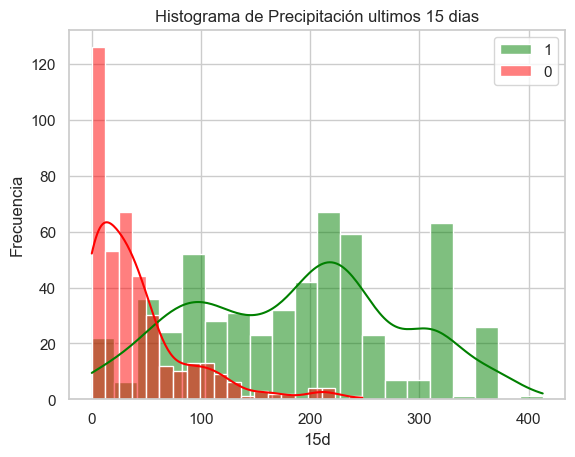

In [11]:
# Configuramos el estilo de Seaborn
sns.set(style="whitegrid")

# Creamos el histograma utilizando Seaborn
sns.histplot(data=df[df['deslizamientos'] == 1],x='15d', bins=20, kde=True, color='green',label='1')
sns.histplot(data=df[df['deslizamientos'] == 0],x='15d', bins=20, kde=True, color='red',label='0')


# Añadimos etiquetas y título
plt.xlabel('15d')
plt.ylabel('Frecuencia')
plt.title('Histograma de Precipitación ultimos 15 dias')
plt.legend()
# Mostramos el histograma
plt.show()

Revisamos si hay valores nulos

In [12]:
#Verificamos si existen valores nulos
df.isnull().sum()

ELEVACION         0
PENDIENT          0
SIM_COB25         0
GEOLOGIA_1        0
24h               0
7d                0
10d               0
15d               0
30d               0
60d               0
90d               0
deslizamientos    0
dtype: int64

Ahora veremos como se comportan las varaibles categoricas para saber como tratarlas

Previamente, se propone convertir las variables categoricas a label numericos mediante la funcion de `OrdinalEncoder()` del paquete sklearn, esta organiza las categorias en orden alfabetico y luego les asigna numeros enteros empezando desde el 0, 1, 2 y asi sucesivamente

### Manejo de variables categoricas

In [13]:
conteo_categorias = df.groupby('SIM_COB25').size().reset_index(name='Conteo')
conteo_categorias

,SIM_COB25,Conteo
0,ABAFAL,4
1,ABAFBA,15
2,ABDALT,2
3,ABDBAJ,2
4,ASD,1
5,BG,6
6,BNAALT,20
7,BNABAJ,9
8,BNDALT,27
9,BNDBAJ,34


Para la anterior varible categorica, vemos que hay varias categorias con muy pocas frcuencias, esto podria ser un problema ya que al momento de entrenar los modelos, puede que ciertos registros con pocas frecuencias queden en el conjunto de datos de testeo y no de entrenamiento, haciendo que el modelo no se entrene o no se aprenda estas categorias que quedan por fuera y no las reconozca.

Veamos la siguiente

In [14]:
conteo_categorias2 = df.groupby('GEOLOGIA_1').size().reset_index(name='Conteo')
conteo_categorias2

,GEOLOGIA_1,Conteo
0,Kv,429
1,Qal,8
2,Qca,4
3,Qca(RMel),25
4,Qca1(RPan),28
5,Qca2(RPan),38
6,Qd,2
7,Ql/Kv,199
8,TOf,15
9,TOg,99


Vemos que es el mismo caso con la variable `GEOLOGIA_1`.

En este caso se sugiere o eliminar esta varaible dado al ruido que puede aportar al modelo o eliminar los registros cuyas categorias pueden causar problemas. Al eliminar los registros, podriamos estar perdiendo informacion util que nos puedes estar aportando las otras columnas

### Correlaciones entre variables independientes

Queremos que haya la menos correlacion lineal y no lineal entre las varaibles independientes, ya que queremos que cada variable aporte su varol unico al modelo, y evitar redundancias

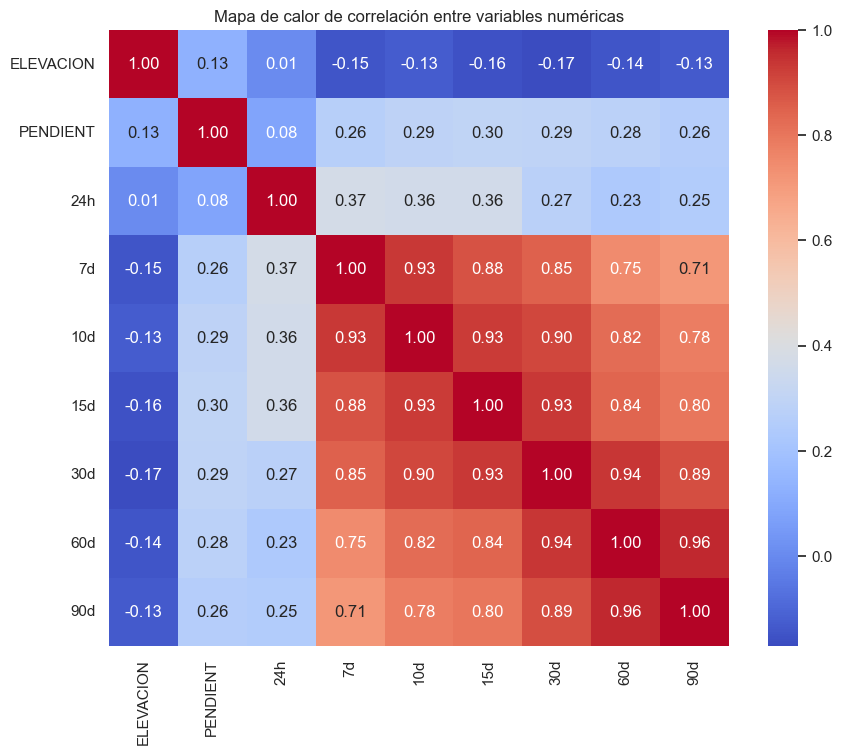

In [15]:
# Correlaciones entre variables independientes
correlation_matrix = X[VAR_numerical_cols].corr(method='pearson')

# Configurar el estilo del mapa de calor
sns.set(style="white")

# Crear el mapa de calor de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

# Añadir título
plt.title('Mapa de calor de correlación entre variables numéricas')

# Mostrar el mapa de calor
plt.show()

Observamos que existe una alta correlacion lineal entre las variables principalmente de precipitacion, dandonos a entender que no son del todo independientes y que a medida que suben los dias (10 dias, 15 dias, 30 dias y así) aumenta su dependencia, es decir, lo que explica una varaible ya lo logra a explicar otra. Esto puede causar overfitting

Ahora, vemos que pasa si entrenamos 1 solo arbol de decision. Esto nos puede servir mucho para explorar a qué el modelo de aprendisaje automatico les esta dando mas importancia.

Como vemos en el arbol de decision entrenado abajo, empieza a hacer reglas de decision para ciertas variables, en este caso, para la variable de P15DIAS es la que empieza a parametrizar las tomas de decisiones

In [16]:
cls=DecisionTreeClassifier(max_depth=3)
modelo_arbol=cls.fit(X[VAR_numerical_cols],y)

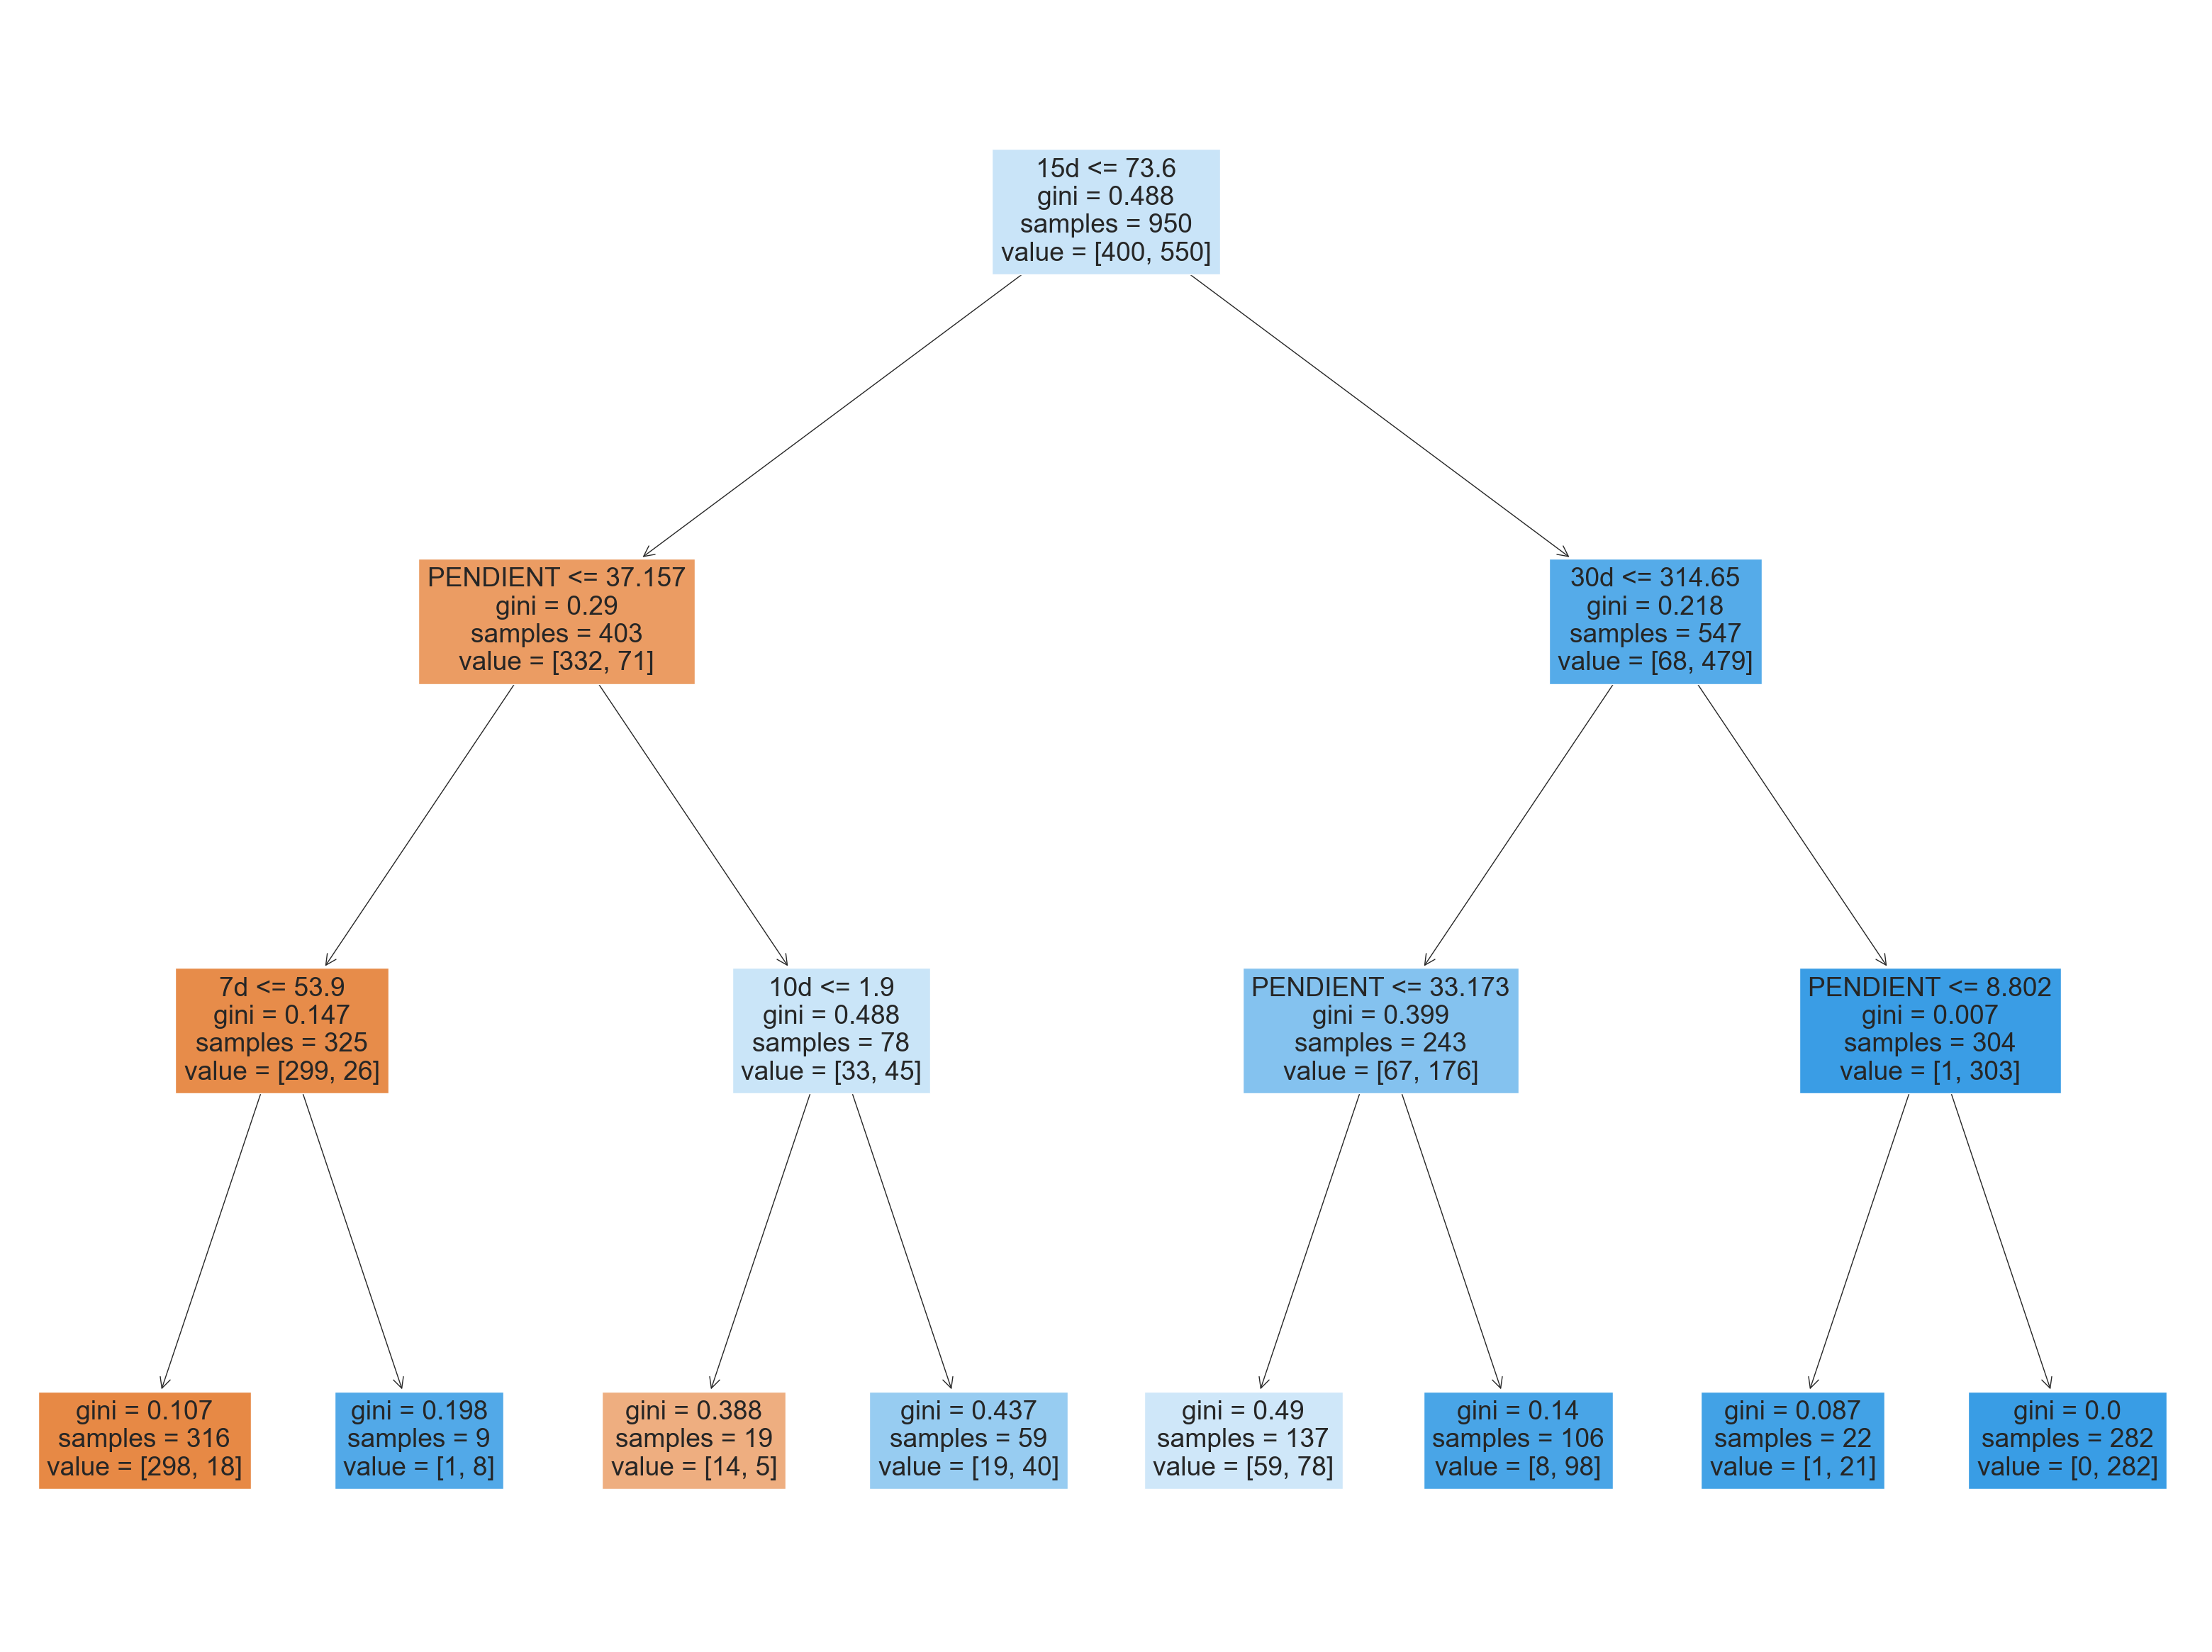

In [17]:
fig=plt.figure(figsize=(40,30))
tree.plot_tree(modelo_arbol,feature_names=X[VAR_numerical_cols].columns,filled=True)
plt.show()

## Modelos de aprendizaje automático propuestos

Dentro de los modelos de aprendizaje automático para problemas de clasificación, se encuentran la familia de árboles de decisión, como Decision Trees, Random Forest, XGBoost (estos 2 últimos de ensamble), SVM (support vector machines), entre otros:


- Máquinas de Vectores de Soporte (SVM):

Busca el hiperplano que mejor separa las clases en un espacio multidimensional.

Puede manejar tanto problemas de clasificación lineal como no lineal mediante el uso de diferentes funciones de kernel.

Es eficaz en conjuntos de datos de tamaño moderado a pequeño y es robusto frente a la presencia de ruido.

Este modelo es ideal que el conjunto de datos esté escalador de manera estandar, ya que las diferencias de magnitudes entre diferentes dimensiones puede llegar a afectar el rendimiento


- Árboles de Decisión:

Representa un conjunto de reglas de decisión en forma de árbol.

Es fácil de entender e interpretar, ya que se puede visualizar fácilmente.

Puede manejar datos numéricos y categóricos y es resistente a valores atípicos.


- Bosques Aleatorios (Random Forest):

Consiste en una colección de árboles de decisión, donde cada árbol se entrena con una muestra aleatoria del conjunto de datos.

Reduce el sobreajuste promediando los resultados de múltiples árboles.

Es robusto y puede manejar conjuntos de datos grandes con muchas características.


- XGBoost (Extreme Gradient Boosting Trees):

Implementa un algoritmo de refuerzo de gradiente extremo, que combina múltiples árboles de decisión para mejorar la precisión del modelo de forma secuencial.

Utiliza técnicas avanzadas de regularización y optimización para mejorar la generalización del modelo y evitar el sobreajuste.

Es altamente eficiente y escalable, adecuado para conjuntos de datos grandes y complejos, y es una opción popular en competiciones de ciencia de datos.


## Metodología propuesta

Ahora, la idea es hacer una tubería de datos tal que cuando lleguen los datos nuevos a estimar, estos pasen por las mismas transformaciones por las que pasaron los datos de entrenamiento. Más precisamente hablando, el pipeline en scikit-learn es una herramienta que te permite concatenar varios pasos de procesamiento de datos y modelado en un solo objeto. Esto facilita la construcción, entrenamiento y evaluación de modelos de aprendizaje automático, ya que puedes encapsular todo el flujo de trabajo en una única estructura.


````{figure} ./figures/Resource-Pipeline-CU-Predictor-Favorabilidad-Compra-Acciones.png
:name: Pipelines_fig
:align: center

Funcionamiento de tuberias (Pipelines) en SciKit-learn
````

De la misma manera, se busca optimizar las estimaciones y la calidad de los modelos, por lo que se usa la metodología de Grid search o búsqueda de malla para optimizar parámetros dentro de los modelos. Es una herramienta poderosa para optimizar los parámetros de un modelo de aprendizaje automático. Permite definir una cuadrícula de valores para diferentes parámetros del modelo y busca exhaustivamente la mejor combinación de estos parameros, a lo que se le llama hiperparametrizacion.

En términos más simples, el GridSearchCV realiza una búsqueda exhaustiva sobre una cuadrícula de valores especificados para los hiperparámetros de un estimador. Esto permite encontrar la combinación óptima de hiperparámetros que maximiza la precisión o cualquier otra métrica de evaluación definida.

La idea detrás del GridSearchCV es que, en lugar de ajustar manualmente los hiperparámetros del modelo y evaluar su rendimiento, el proceso se automatiza y se realiza de manera sistemática. Esto ahorra tiempo y esfuerzo, ya que el GridSearchCV evalúa todas las combinaciones posibles de los hiperparámetros dentro de la cuadrícula especificada y selecciona la mejor combinación según la métrica de evaluación especificada.


````{figure} ./figures/Grid_serach.png
:name: Grid_search_fig
:align: center

Funcionamiento de Busqueda de malla (Grid_search) en SciKit-learn
````

Por último, se propone usar validación cruzada aleatoria y dividida. Esto con el proposito de no usar la clasica division unitaria de entrenamiento-pruba, ya que en este tipo de división el entrenamiento o aprendizake del modelo puede quedar sesgado debido a que al dividir aleatoriamente no sabemos con que proporción de los datos el modelo aprende, por ejemplo, al dividir una sola vez el conjunto de datos nos puede quedar que en el conjunto de test solo haya valores con el label de 0 (no deslizamiento en este caso) y en el entrenamiento solo existan registros del label 1 (deslizamientos), esto puede ocasionar que el modelo no aprenda de la manera más optima.

Con la validación cruzada aleatoria y dividida (shuffle-split). En la validación cruzada de división aleatoria, cada división (split) está compuesta de tanto train_size puntos (disyuntos) para el conjunto de entrenamiento y tantos test_size puntos (disjuntos) para el conjunto de prueba, se fijen inicialmente. Esta división se repite n veces, de forma aleatoria. Por ejemplo en la siguiente imagen, para la ejecución de cuatro iteraciones de división de un conjunto de datos que consta de 10 puntos, con un conjunto de entrenamiento de 5 puntos y conjuntos de prueba de 2 puntos cada uno

````{figure} ./figures/shuffle_split.png
:name: shuffle_split_fig
:align: center

Funcionamiento de Validación cruzada aleatoria (Shuffle split) en SciKit-learn
````

### Métricas de Evaluación propuestas

En el desarrollo de nuestro modelo de clasificación binaria para la identificación de zonas propensas a deslizamientos de tierra, enfrentamos una decisión crucial en la selección de la métrica de rendimiento a optimizar. La esencia de nuestra clasificación distingue dos categorías claves: la clase positiva (1), que indica la presencia de un deslizamiento de tierra, y la clase negativa (0), que señala su ausencia.


````{figure} ./figures/matriz_confusion_ejemplo.png
:name: matriz_confusion_fig
:align: center

Matriz de Confusión
````

Si vemos la anterior matriz de confusió, para nuestro análisis, es vital priorizar la reducción de los falsos negativos (FN - false negatives), es decir, las situaciones donde el modelo predice erróneamente que no habrá deslizamiento de tierra cuando en realidad sí ocurre. La ocurrencia de estos errores podría tener consecuencias significativas en términos de seguridad y preparación ante desastres naturales.



#### Tipos de métricas

**Accuracy**

Ya vimos una forma de resumir el resultado en la matriz de confusión, calculando su accuracy, que puede expresarse como

$$ \text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN} $$

En otras palabras, el accuracy es el número de predicciones correctas (TP y TN) dividido por el número de todas las muestras (todas las entradas de la matriz de confusión sumadas).


**Precision**

Precision mide cuántas de las muestras predichas como positivas son realmente positivas, es decir, precision intenta responder a la siguiente pregunta: ¿qué proporción de identificaciones positivas fue correcta?

$$ \text{Precision} = \frac{TP}{TP + FP} $$

Precision se utiliza como métrica de rendimiento cuando el objetivo es limitar el número de falsos positivos.


**Recall**

El recall mide cuántas de las muestras de la clase positiva son realmente predichas positivas, es decir, recall intenta responder a la siguiente pregunta: ¿qué proporción de positivos reales se identificó en forma correcta?

$$ \text{Recall} = \frac{TP}{TP + FN} $$

Recall se utiliza como métrica de rendimiento cuando el objetivo es limitar el número de falsos negativos.

Con este objetivo en mente, la métrica que hemos decidido optimizar es el recall (también conocido como sensibilidad). El recall mide la capacidad del modelo para identificar correctamente los verdaderos casos positivos de deslizamientos de tierra entre todos los casos reales. Un recall alto implica que el modelo es efectivo en la detección de la mayoría de los eventos de deslizamientos, minimizando así el riesgo de no alertar sobre posibles desastres.

Optimizar el recall, sin embargo, puede llevar a un incremento en los falsos positivos —predicciones incorrectas de deslizamientos donde no ocurrirán—. Aunque esto podría considerarse un costo menor en comparación con los riesos de omitir alertas reales, es crucial implementar un equilibrio adecuado con la precisión, que mide la proporción de predicciones positivas correctas entre todas las predicciones positivas realizadas por el modelo.

Nuestra estrategia para calibrar el modelo se centra en maximizar el recall para asegurar una efectiva detección de todos los potenciales deslizamientos de tierra, mientras mantenemos un nivel aceptable de precisión para limitar las falsas alarmas. Esta aproximación está diseñada para ofrecer la máxima protección y preparación, alineándose con las prioridades de seguridad y respuesta ante emergencias de nuestra comunidad.

## Desarrollo

Dividimos el conjunto de datos de entrenamiento de manera aleatoria y dividida, entrenando con 60% de los registros y testeando con el 40% de los registros en cada 10 split. Pero antes sacamos un conjunto de datos de Validación para medir rendimientos

In [18]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2)

In [19]:
shuffle_split = ShuffleSplit(test_size=.4, train_size=.6, n_splits=10)

### Modelo Support Vector Machines

Definimos el preprocesamiento de datos, acá buscamos aplicar diversas transformaciones a diferentes columnas antes de entrenar el modelo

In [20]:
# Paso 1: Define el preprocesamiento de datos
preprocessor_svc = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), VAR_numerical_cols)
    ],
    remainder='passthrough'
)

Con el objetivo de hacer un grid search (busqueda de malla), para hiperparametrizar cada uno de las 3 clases de clasificadores, se define param_grid, que contiene diferentes combinaciones de parametros para cada uno de los modelos

In [21]:
param_grid_svc={'classifier__C': [0.1, 1, 10], 'classifier__kernel': ['linear', 'rbf','sigmoid'],'classifier__gamma':[0.01, 0.1, 1],'classifier__probability':[True]}

El pipeline se utiliza para dejar encapsulado los pasos de preprocesamientos necesario previos a la estimación. Asi, al estimar con este objeto tipo `Pipeline` nos aseguramos de que los nuevos datos sin procesar se reprocesen antes de la estimación nueva

In [22]:
pipeline_svc = Pipeline([
        ('preprocessor', preprocessor_svc),
        ('classifier', SVC())
    ])

Utilizamos GridSearchCV para hacer todas las combinaciones posibles y buscar los mejores parámetros

In [23]:
grid_search_svc = GridSearchCV(pipeline_svc, param_grid_svc, cv=shuffle_split, scoring='recall')

In [24]:
ajuste_svc=grid_search_svc.fit(X_train, y_train)

In [25]:
# Imprimir los resultados
print("Modelo ganador Support Vector Machines:", ajuste_svc.best_estimator_)
print("Mejor combinación de parámetros:", ajuste_svc.best_params_)
print("Puntaje de recall (recuperación) en el conjunto de entrenamiento:", ajuste_svc.best_score_)

Modelo ganador Support Vector Machines: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['ELEVACION', 'PENDIENT',
                                                   '24h', '7d', '10d', '15d',
                                                   '30d', '60d', '90d'])])),
                ('classifier', SVC(C=0.1, gamma=1, probability=True))])
Mejor combinación de parámetros: {'classifier__C': 0.1, 'classifier__gamma': 1, 'classifier__kernel': 'rbf', 'classifier__probability': True}
Puntaje de recall (recuperación) en el conjunto de entrenamiento: 0.9746457198886528


### Modelo Random Forest y Gradient Boosting Classifier

Estos 2 modelos se desarrollan juntos ya que tienen el mismo preprocesamientos de datos, a diferencia de del Support Vector Machines que necestia un preprosesamiento diferente

Definimos nuestro diccionario de clasificadores. Acá buscamos dejar en una estructura los 2 tipos de clasificadores que usaremos

In [26]:
classifiers = {
    'RandomForestClassifier': RandomForestClassifier(),
    'GradientBoostingClassifier': GradientBoostingClassifier()
}

Con el objetivo de hacer un grid search (busqueda de malla), para hiperparametrizar cada uno de las 2 clases de clasificadores de la familia de arboles, se define param_grid, que contiene diferentes combinaciones de parametros para cada uno de los 2 modelos

In [27]:
param_grid = {
    'RandomForestClassifier': {'classifier__n_estimators': [50, 100, 200], 'classifier__max_depth': [None, 10, 20],'classifier__min_samples_split': [2, 5, 10],'classifier__min_samples_leaf': [1, 2, 4]},
    'GradientBoostingClassifier': {'classifier__n_estimators': [50, 100, 200], 'classifier__learning_rate': [0.01, 0.1, 0.2], 'classifier__max_depth': [None, 10, 20],'classifier__min_samples_split': [2, 5, 10]}
}

Ahora juntamos los 2 pasos anteriores para hacer un pipeline para cada tipo de modelo. El pipeline se utiliza para dejar encapsulado los pasos de preprocesamientos necesario previos a la estimación. Asi, al estimar con este objeto tipo `Pipeline` nos aseguramos de que los nuevos datos sin procesar se reprocesen antes de la estimación nueva

In [28]:
# Definir un diccionario de pipelines
pipelines = {}
for name, classifier in classifiers.items():
    pipelines[name] = Pipeline([
        ('classifier', classifier)
    ])

In [29]:
pipelines

{'RandomForestClassifier': Pipeline(steps=[('classifier', RandomForestClassifier())]),
 'GradientBoostingClassifier': Pipeline(steps=[('classifier', GradientBoostingClassifier())])}

In [30]:

# Utiliza GridSearchCV para hacer todas las combinaciones posibles y buscar los mejores parámetros
best_models = {}
for name, pipeline in pipelines.items():
    grid_search2 = GridSearchCV(pipeline, param_grid[name], cv=shuffle_split,scoring='recall')
    grid_search2.fit(X_train, y_train)
    msg_training=f"Rendimiento en training -> {name} \n Puntaje recall en entrenamiento: {grid_search2.best_score_}, \n modelo ganador: {grid_search2.best_estimator_} \n mejor combinacion de parametros: {grid_search2.best_params_}"
    print(msg_training)
    best_models[name] = grid_search2.best_estimator_



Rendimiento en training -> RandomForestClassifier 
 Puntaje recall en entrenamiento: 0.9381065581773349, 
 modelo ganador: Pipeline(steps=[('classifier', RandomForestClassifier(max_depth=10))]) 
 mejor combinacion de parametros: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}
Rendimiento en training -> GradientBoostingClassifier 
 Puntaje recall en entrenamiento: 0.9395709925143134, 
 modelo ganador: Pipeline(steps=[('classifier',
                 GradientBoostingClassifier(max_depth=10, min_samples_split=10,
                                            n_estimators=200))]) 
 mejor combinacion de parametros: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 10, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 200}


Acá podemos ver un diccionario que contiene los modelos ganadores para cada tipo, es decir,un modelo ganador para Support Vectors Machines, un ganador de RandomForest y otro ganador de GradientBoostingClassifier. Arriba podemos ver como le fue a cada uno en training

In [31]:
best_models['SVC']=ajuste_svc.best_estimator_

In [32]:
best_models

{'RandomForestClassifier': Pipeline(steps=[('classifier', RandomForestClassifier(max_depth=10))]),
 'GradientBoostingClassifier': Pipeline(steps=[('classifier',
                  GradientBoostingClassifier(max_depth=10, min_samples_split=10,
                                             n_estimators=200))]),
 'SVC': Pipeline(steps=[('preprocessor',
                  ColumnTransformer(remainder='passthrough',
                                    transformers=[('num', StandardScaler(),
                                                   ['ELEVACION', 'PENDIENT',
                                                    '24h', '7d', '10d', '15d',
                                                    '30d', '60d', '90d'])])),
                 ('classifier', SVC(C=0.1, gamma=1, probability=True))])}

Acá buscamos saber cual de esas 3 clases de modelo diferentes es mejor, para eso los probamos con el conjunto de datos de validación visto anteriormente y obtenemos sus puntajes

In [33]:
# Evaluación de rendimiento en el conjunto de prueba
test_accuracies = {}
for name, model in best_models.items():
    y_pred = model.predict(X_valid)
    accuracy = recall_score(y_valid, y_pred)
    test_accuracies[name] = accuracy
    print(f"Recall en test para {name}: {accuracy}")

Recall en test para RandomForestClassifier: 0.9423076923076923
Recall en test para GradientBoostingClassifier: 0.9519230769230769
Recall en test para SVC: 0.9519230769230769


Como vemos, el modelo ganador es Support Vector Machines con una recall (recuperación) de 95.2 % en validación

In [49]:
# Selección del mejor modelo basado en el rendimiento en el conjunto de test
# best_model_name = max(test_accuracies, key=test_accuracies.get)
# the_best_model = best_models[best_model_name]
the_best_model=best_models['SVC']

# print(f"\nEl mejor modelo es: {best_model_name} con un accuracy en test de {test_accuracies[best_model_name]}")
the_best_model
print(f"\nEl mejor modelo es: {the_best_model['classifier']} con un accuracy en test de {test_accuracies['SVC']}")


El mejor modelo es: SVC(C=0.1, gamma=1, probability=True) con un accuracy en test de 0.9519230769230769


In [50]:
the_best_model['classifier']

SVC(C=0.1, gamma=1, probability=True)

Miramos el reporte de métricas completas

In [37]:
# Calcular las métricas para el SVC
y_pred_1 = best_models['SVC'].predict(X_valid)
precision1 = precision_score(y_valid, y_pred_1)
recall1 = recall_score(y_valid, y_pred_1)
accuracy1 = accuracy_score(y_valid, y_pred_1)
f1_score1 = f1_score(y_valid, y_pred_1)

# Calcular las métricas para el RandomForest
y_pred2 = best_models['RandomForestClassifier'].predict(X_valid)
precision2 = precision_score(y_valid, y_pred2)
recall2 = recall_score(y_valid, y_pred2)
accuracy2 = accuracy_score(y_valid, y_pred2)
f1_score2 = f1_score(y_valid, y_pred2)

# Calcular las métricas para el XGBoost
y_pred3 = best_models['GradientBoostingClassifier'].predict(X_valid)
precision3 = precision_score(y_valid, y_pred3)
recall3 = recall_score(y_valid, y_pred3)
accuracy3 = accuracy_score(y_valid, y_pred3)
f1_score3 = f1_score(y_valid, y_pred3)

In [38]:
data_reporte = {
    'Modelo': ['Support Vector Classifier', 'Random Forest Classifier', 'XGBoost Classifier'],
    'Precisión (Precision)': [precision1, precision2, precision3],
    'Sensibilidad (Recall)': [recall1, recall2, recall3],
    'Exactitud (Accuracy)': [accuracy1, accuracy2, accuracy3],
    'F1-score': [f1_score1, f1_score2, f1_score3]
}

df_reporte = pd.DataFrame(data_reporte)

## Resumen rendimiento de modelos

In [39]:
df_reporte

,Modelo,Precisión (Precision),Sensibilidad (Recall),Exactitud (Accuracy),F1-score
0,Support Vector Classifier,0.744361,0.951923,0.794737,0.835443
1,Random Forest Classifier,0.852174,0.942308,0.878947,0.894977
2,XGBoost Classifier,0.853448,0.951923,0.884211,0.900000


## Visibilidad y entendimiento del modelo

En esta sección buscamos entender cómo es el modelo ganador, mediante varias tecnicas

El "feature importance" (importancia de las características) en un modelo de aprendizaje automático, indica cuánto contribuye cada característica (o atributo) al rendimiento general del modelo en la tarea de predicción. Es una medida útil para entender qué características son más relevantes para la predicción de la variable objetivo.

En este caso podemos ver que la variable `15d` (precipitación acumulada en los ultimos 10 dias en mm) aporta mas 50% en la prediccion del deslizamiento, dando a entender que es importante si se quiere estimar si hay deslizamientos o no

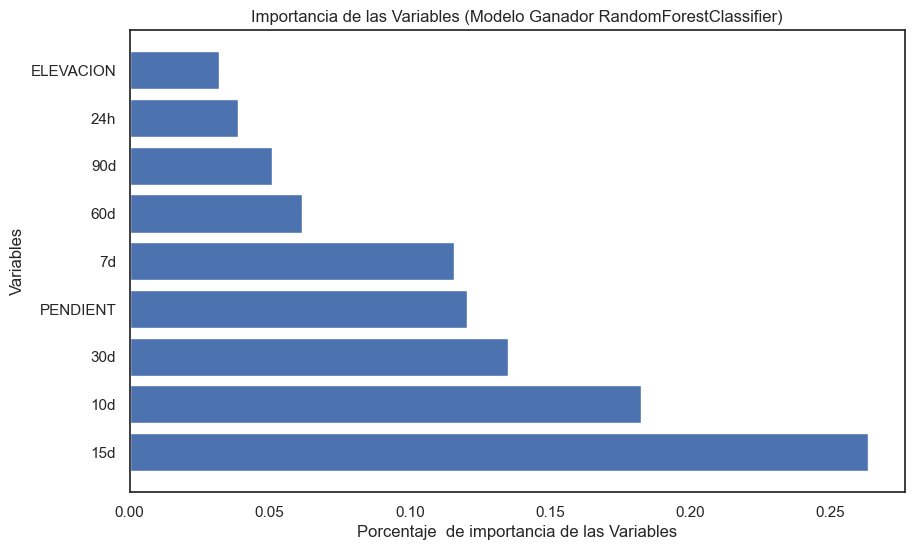

In [40]:
# Obtener la importancia de las características
feature_importances = best_models['RandomForestClassifier']['classifier'].feature_importances_

# Obtener los nombres de las características
feature_names = X_train.columns  # Reemplaza esto con el nombre de tus características si tienes

# Ordenar las características por su importancia
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_feature_importances = feature_importances[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]

# Graficar la importancia de las características
plt.figure(figsize=(10, 6))
plt.barh(sorted_feature_names, sorted_feature_importances)
plt.xlabel('Porcentaje  de importancia de las Variables')
plt.ylabel('Variables')
plt.title('Importancia de las Variables (Modelo Ganador RandomForestClassifier)')
plt.show()

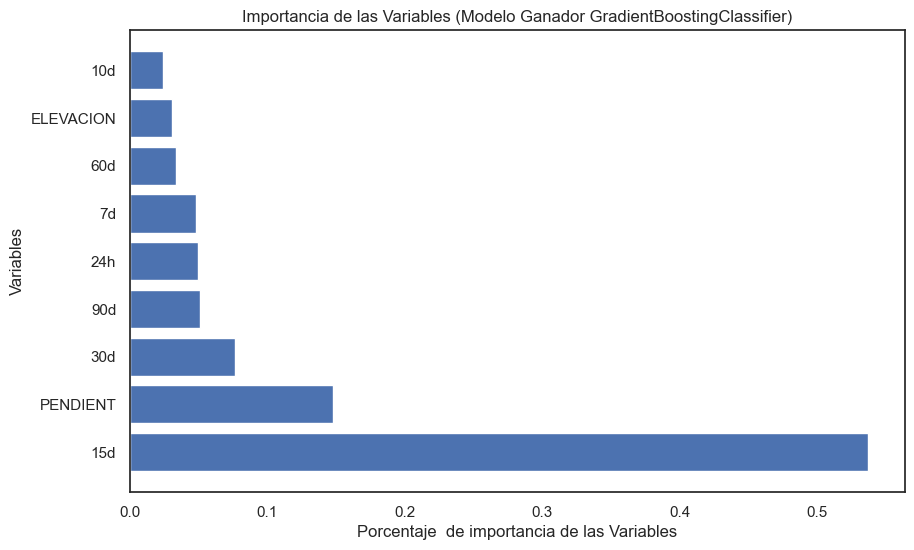

In [41]:
# Obtener la importancia de las características
feature_importances = best_models['GradientBoostingClassifier']['classifier'].feature_importances_

# Obtener los nombres de las características
feature_names = X_train.columns  # Reemplaza esto con el nombre de tus características si tienes

# Ordenar las características por su importancia
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_feature_importances = feature_importances[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]

# Graficar la importancia de las características
plt.figure(figsize=(10, 6))
plt.barh(sorted_feature_names, sorted_feature_importances)
plt.xlabel('Porcentaje  de importancia de las Variables')
plt.ylabel('Variables')
plt.title('Importancia de las Variables (Modelo Ganador GradientBoostingClassifier)')
plt.show()

## Aplicación del modelo

Esta sección tiene como objetivo aplicar el modelo ganador con los una captura de los datos de la API, los cuales estan en la variable `df_nuevos_datos`

In [42]:
# Definir función para anticipar probabilidades 
def predecir_probabilidades(df_nuevos_datos, modelo, columnas):
    # seleccionar columnas
    datos_seleccionados = df_nuevos_datos[columnas]
    # Predecir probabilidades
    probabilidades = modelo.predict_proba(datos_seleccionados)[:,1]
    # Extraer las probabilidades para la clase positiva
    df_nuevos_datos['Probabilidad'] = probabilidades

    return df_nuevos_datos

In [43]:
# Definir las características para el DataFrame
columnas_P = ['ELEVACION', 'PENDIENT', '24h', '7d', '10d', '15d', '30d', '60d', '90d']

# Utilizar la función para predecir probabilidades en nuevos datos
probabilidades_nuevos_datos = predecir_probabilidades(df_nuevos_datos, best_models['SVC'],columnas_P)

In [44]:
# Convierte la columna 'geometry' a un DataFrame separado
df_p = probabilidades_nuevos_datos.drop(columns='geometry')


In [45]:
probabilidades_nuevos_datos.head(3)

,FID,OBJECTID_1,COD_COB25_,NOM_COB25,SIM_COB25,GEOLOGIA_1,GEOLOGIA_2,ELEVACION,PENDIENT,Shape_Leng,...,id,24h,7d,10d,15d,30d,60d,90d,geometry,Probabilidad
0,0,1,31111,Bosque mixto denso alto de tierra firme,BNDALT,Ke,Formacion Espinal,2061.900391,53.671722,498.976929,...,23,65.6,115.0,0.0,148.0,189.2,0.0,0.0,"POLYGON ((1044979.707 873707.899, 1044846.653 ...",0.824757
1,1,2,31111,Bosque mixto denso alto de tierra firme,BNDALT,Ke,Formacion Espinal,2127.599609,49.409256,995.407241,...,23,65.6,115.0,0.0,148.0,189.2,0.0,0.0,"POLYGON ((1044979.752 873984.389, 1044719.714 ...",0.824757
2,2,3,31111,Bosque mixto denso alto de tierra firme,BNDALT,Ke,Formacion Espinal,2235.685791,22.863684,1026.961430,...,23,65.6,115.0,0.0,148.0,189.2,0.0,0.0,"POLYGON ((1044979.796 874260.878, 1044775.326 ...",0.824757
